# Debut

In [4]:
from jax import random, jit, vmap
import os
path = os.getcwd()
print("Old path:", path)
path = (path.split('/'))
path = path[:path.index("ABC-SBI")+1]
path = '/'.join(path)
print("New path:", path)
os.chdir(path)
from functions.simulation import get_dataset, ABC_epsilon, get_epsilon_star
from functions.training import train_loop
from functions.SBC import SBC_epsilon, plot_SBC, find_grid_explorative, post_pdf_z
import jax.numpy as jnp
import time
import pickle 
import lzma
from jax.scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
@jit
def prior_simulator(key):
    return random.normal(key, (1,))*SIGMA0 + MU0

@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,))*SIGMA + theta).astype(float)

@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true))**2

def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))


Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


In [107]:
from functions.SBC import logratio_z, logratio_batch_z, post_pdf_z, find_grid_explorative
def true_post(z):
    mu_post = (MU0*SIGMA**2 + SIGMA0**2 * np.sum(z))/(SIGMA0**2*len(z) + SIGMA**2)
    sigma2_post = 1/(1/SIGMA0**2 + len(z)/SIGMA**2)
    return stats.norm(loc = mu_post, scale = np.sqrt(sigma2_post))

def true_ratio_z(mus, z, prior, posterior):
    return posterior(z).pdf(mus)/prior.pdf(mus)

def true_decision_z(mus, z, prior, posterior):
    return 1/(1+1/true_ratio_z(mus, z, prior, posterior))

def true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior):
    pseudo = true_pseudo_post(mus, bar_xobs, epsilon, prior)
    Z_pseudo = np.trapz(pseudo, mus)
    return posterior(z).pdf(mus)/pseudo*Z_pseudo

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def true_pseudo_post(mus, bar_xobs, epsilon, prior):
    return prior.pdf(mus)*(norm.cdf(bar_xobs+np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)) - norm.cdf(bar_xobs-np.sqrt(epsilon), loc = mus, scale = SIGMA/np.sqrt(N_DATA)))

def true_pseudo_decision_z(mus, z, bar_xobs, epsilon, prior, posterior):
    return 1/(1+1/true_pseudo_ratio_z(mus, z, bar_xobs, epsilon, prior, posterior))

def decision_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_z(params, mus, z)))
def decision_batch_z(params, mus, z):
    return 1/(1+jnp.exp(-logratio_batch_z(params, mus, z)))

def ABC_gauss_single(key, true_data, epsilon):
    key, key_xbar = random.split(key)
    xbar = random.truncated_normal(key_xbar, lower = (jnp.mean(true_data)-jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)), upper = (jnp.mean(true_data)+jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)))*jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)) + MU0
    dist = (jnp.mean(true_data)-xbar)**2
    key, key_z = random.split(key)
    z = random.normal(key_z, (len(true_data),))*SIGMA
    z = z-jnp.mean(z)+xbar
    key, key_mu = random.split(key)
    mu = random.normal(key_mu, (1,))*SIGMA/jnp.sqrt(len(true_data)) + xbar
    return z, mu, dist


def ABC_gauss(key, true_data, epsilon, N_ABC):
    keys = random.split(key, N_ABC+1)
    zs, mus, dists = vmap(jit(ABC_gauss_single), (0, None, None))(keys[1:], true_data, epsilon)
    return zs, mus, dists, keys[0]

def get_epsilon_star_gauss(key, acceptance_rate, n_points, prior_simulator, data_simulator, discrepancy, true_data, quantile_rate = .9, epsilon = jnp.inf, return_accept = False):
    new_epsilon = epsilon
    accept = 1.
    
    datas, thetas, dists, key = ABC_gauss(key, true_data, epsilon, n_points)
    if epsilon == jnp.inf:
        print("Distances: min = ", jnp.min(dists), "max = ", jnp.max(dists), "mean = ", jnp.mean(dists), "std = ", jnp.std(dists))
    while accept > acceptance_rate:
        epsilon = new_epsilon
        new_epsilon = float(jnp.quantile(dists, quantile_rate))
        datas, thetas, dists, key = ABC_gauss(key, true_data, new_epsilon, n_points)
        key, subkey = random.split(key)
        keys_pred = random.split(subkey, n_points)
        datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, thetas)
        new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, true_data)
        accept = jnp.mean(new_dists < new_epsilon)
        epsilon = new_epsilon
        print("epsilon: ", epsilon, "acceptance rate: ", accept)
    if return_accept: 
        return epsilon, accept, key
    return epsilon, key

def get_dataset_gauss(key, n_points, prior_simulator, data_simulator, discrepancy, epsilon, true_data):
    n_points = n_points//2
    zs0, thetas0, _, key = ABC_gauss(key, true_data, epsilon, n_points)
    _, thetas1, _, key = ABC_gauss(key, true_data, epsilon, n_points)    
    zs = jnp.concatenate([zs0, zs0], axis=0)
    thetas = jnp.concatenate([thetas0, thetas1], axis=0)
    ys = jnp.append(jnp.zeros(n_points), jnp.ones(n_points)).astype(int)
    Xs = jnp.concatenate([thetas, zs], axis=1)
    return Xs, ys, key

The standard NRE output is the ratio:
$$\hat r(x\mid \theta) \approx r(x\mid \theta) = \frac{f(x\mid\theta)}{p(x)} = \frac{\pi(\theta\mid x)}{\pi(\theta)}$$

The posterior approximation is then 
$$\hat \pi(\theta\mid x) \propto \pi(\theta) \cdot\hat r(x\mid \theta)$$

Here we train the NRE classifier with datas from the ABC joint pseudo posterior $\pi_\epsilon(\theta,x\mid x_o)$ with $\epsilon \in ] 0 , + \infty [$.

The ABC-NRE output is then:
$$\hat r_\epsilon(x\mid \theta, x_o) \approx r_\epsilon(x\mid \theta, x_o) =  \frac{\pi(\theta\mid x)}{\pi_\epsilon(\theta\mid x_o)}$$

and the posterior approximation becomes : 

$$\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$$

where $ \hat \pi_\epsilon(\theta\mid x_o) $ is a KDE approximation of the ABC pseudo posterior that plays the role of the ABC correction. 


Here we compare: 
- the ABC-NRE approximation with the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \hat \pi_\epsilon(\theta\mid x_o) \cdot \hat r_\epsilon(x\mid \theta, x_o)$.
- the ABC-NRE approximation without the KDE correction: $\hat \pi(\theta\mid x, x_o) \propto \pi(\theta) \cdot r_\epsilon(x\mid \theta, x_o)$. 
- the ABC pseudo posterior: $\pi_\epsilon(\theta\mid x_o)$
- the true posterior: $\pi(\theta\mid x_o)$.

Here we consider the Gaussian toy model 
$$\mu \sim \mathcal N(0, 10^2) \quad x = (x_1, \cdots, x_n) \sim \mathcal N(\mu, 1)$$

Even with $n = 10$, we remark that $r_\epsilon (x \mid \theta, x_o) >> \pi_\epsilon(\theta\mid x_o) \approx \pi(\theta)$ so there is no the correction does not change the posterior approximation. 

When $\epsilon$ is too small, $r_\epsilon(x\mid \theta, x_o) \propto 1$ and $\pi_epsilon(\theta\mid x_o) \approx \pi(\theta\mid x_o)$. The NRE approximation without the correction is then the prior and becomes close to the posterior with the ABC correction. 


# Data simulation ($x_o$)

In [28]:
key = random.PRNGKey(0)
SIGMA0 = 10.
MU0 = 0.
SIGMA = 1.
TRUE_MU = 2.*SIGMA0
N_DATA = 5
MODEL_ARGS = [SIGMA]
PRIOR_ARGS = [MU0, SIGMA0]

key, subkey = random.split(key)
TRUE_DATA = random.normal(subkey, (N_DATA,))*SIGMA + TRUE_MU

PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
MINN, MAXX = norm.ppf(1e-5, loc = MU0, scale = SIGMA0), norm.ppf(1-1e-5, loc = MU0, scale = SIGMA0)

N_EPSILON = 1000000
zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, np.inf, N_EPSILON)
ALPHAS = [.99,.75,.5,.1,.01, .001, .0001]
EPSILONS = {1.: jnp.inf}
for alpha in ALPHAS: 
    EPSILONS[alpha] = jnp.quantile(dists, alpha)

ALPHAS = [1.]+ALPHAS

In [ ]:
ALPHAS = [1., .99, .75, .5, .1, .01, .001, .0001]

# Training loop

----------------------
ALPHA = 1.0 EPSILON = inf
----------------------
Simulations of the testing dataset...
Test check: True
Time to simulate the testing dataset: 0.80s

Simulations of the training dataset...
Train check: True
Time to simulate the training dataset: 0.93s

Training the neural network...
Initial accuracy: 48.90%, Initial test accuracy: 48.61%
Training for 100 epochs...
Epoch 1/100, mean train accuracy: 94.83%, mean test accuracy: 96.06%, lr scale: 1.0 in 5.28 sec
Epoch 2/100, mean train accuracy: 95.66%, mean test accuracy: 95.70%, lr scale: 1.0 in 6.05 sec
Epoch 3/100, mean train accuracy: 95.91%, mean test accuracy: 95.83%, lr scale: 1.0 in 4.73 sec
Epoch 4/100, mean train accuracy: 95.92%, mean test accuracy: 95.73%, lr scale: 1.0 in 5.12 sec
Epoch 5/100, mean train accuracy: 96.00%, mean test accuracy: 96.05%, lr scale: 1.0 in 5.29 sec
Epoch 6/100, mean train accuracy: 96.00%, mean test accuracy: 96.16%, lr scale: 1.0 in 4.90 sec
Epoch 7/100, mean train accuracy: 9

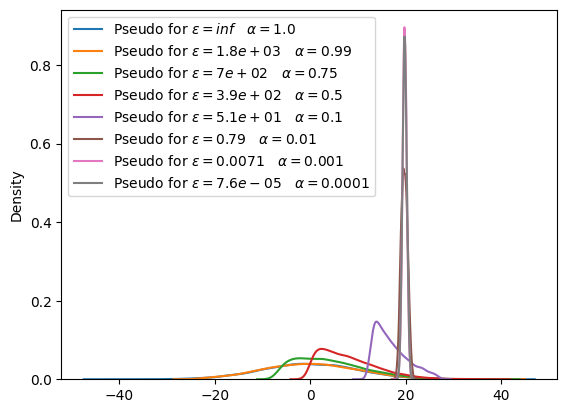

In [29]:
key = random.PRNGKey(0)


N_POINTS_TRAIN = 100000
N_POINTS_TEST = 10000
N_POINTS_EPS = 1000


N_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = .5
RTOL = 1e-4  
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 7
WDECAY = .001
N_GRID_FINAL = 10000
N_GRID_EXPLO = 1000




PARAMS = {}
TEST_ACCURACY = {}
for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    print(f"----------------------\nALPHA = {alpha} EPSILON = {EPSILON_STAR:.2}\n----------------------")


    print("Simulations of the testing dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_test, y_test, key = get_dataset_gauss(subkey, N_POINTS_TEST, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Test check:", np.any(X_test[:,0]!=np.sort(X_test[:,0])))
    print('Time to simulate the testing dataset: {:.2f}s\n'.format(time.time()-time_sim))


    print("Simulations of the training dataset...")
    time_sim = time.time()
    key, subkey = random.split(key)
    X_train, y_train, key = get_dataset_gauss(subkey, N_POINTS_TRAIN, prior_simulator, data_simulator, discrepancy, EPSILON_STAR, TRUE_DATA)
    print("Train check:", np.any(X_train[:,0]!=np.sort(X_train[:,0])))
    print('Time to simulate the training dataset: {:.2f}s\n'.format(time.time()-time_sim))
    
    print("Training the neural network...")
    time_nn = time.time()
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(key, N_EPOCHS, NUM_LAYERS, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE, NUM_BATCH, LEARNING_RATE, WDECAY, PATIENCE, COOLDOWN, FACTOR, RTOL, ACCUMULATION_SIZE, LEARNING_RATE_MIN, prior_simulator, data_simulator, discrepancy, true_data = TRUE_DATA, X_train = X_train, y_train = y_train, X_test = X_test, y_test =  y_test, N_POINTS_TRAIN = N_POINTS_TRAIN, N_POINTS_TEST = N_POINTS_TEST, epsilon = EPSILON_STAR, verbose = True)
    print('Time to train the neural network: {:.2f}s\n'.format(time.time()-time_nn))

    PARAMS[alpha] = params
    TEST_ACCURACY[alpha] = test_accuracy[-1]
    sns.kdeplot(X_test[:,0].reshape(-1), label = f"Pseudo for $\epsilon = {EPSILON_STAR:.2}\quad \\alpha = {alpha:.2}$")
plt.legend()
plt.show()



# Display results


## ABC Pseudo posterior

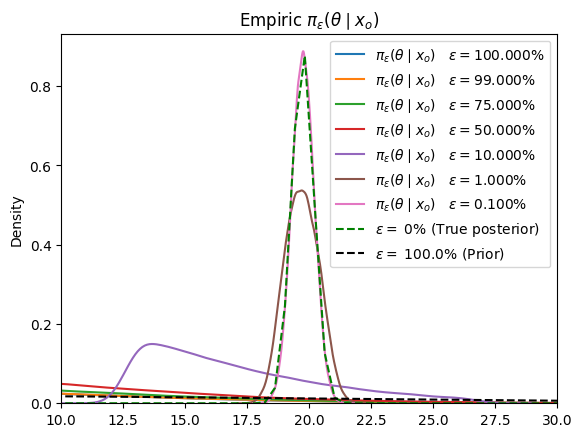

In [50]:
for alpha in ALPHAS:
    zs, mus, dists, key = ABC_gauss(key, TRUE_DATA, EPSILONS[alpha], 100000)
    label = "$\pi_\epsilon(\\theta\mid x_o) \quad \epsilon = ${:.3%}".format(alpha)
    sns.kdeplot(mus.reshape(-1), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("Empiric $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

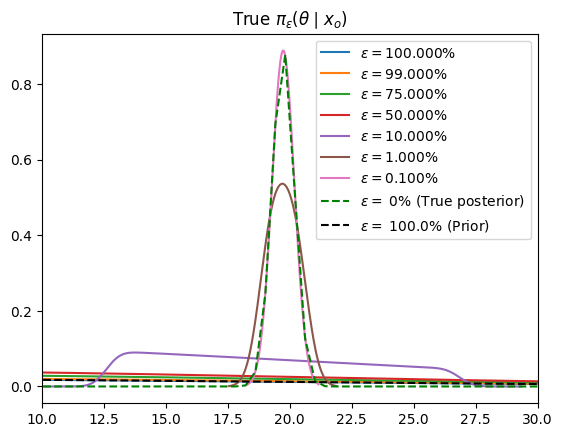

In [51]:
prior = stats.norm(loc = MU0, scale = SIGMA0)
for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 1000, 1000, MINN, MAXX)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid_pseudo, pdf_pseudo/np.trapz(pdf_pseudo, grid_pseudo), label = label)
x = np.linspace(-200, 200, 1000)
plt.plot(x, true_post(TRUE_DATA).pdf(x), label = "$\epsilon =$ 0% (True posterior)", linestyle = "--", color = "green")
plt.plot(x, stats.norm.pdf(x, loc = MU0, scale = SIGMA0), label = "$\epsilon =$ 100.0% (Prior)", linestyle = "--", color = "black")
plt.title("True $\pi_\epsilon(\\theta\mid x_o)$")
plt.legend()
plt.xlim(TRUE_MU-10, TRUE_MU+10)
plt.show()

## ABC-NRE Approximation

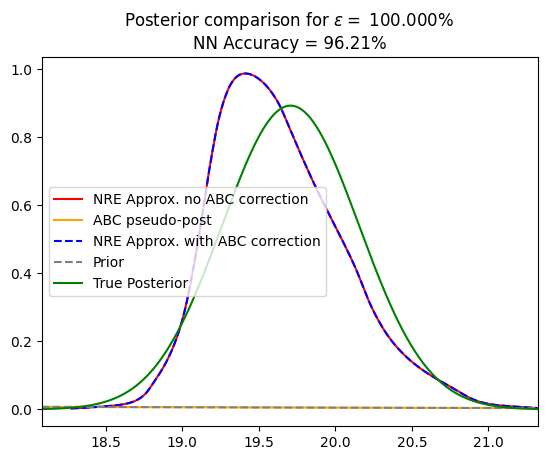

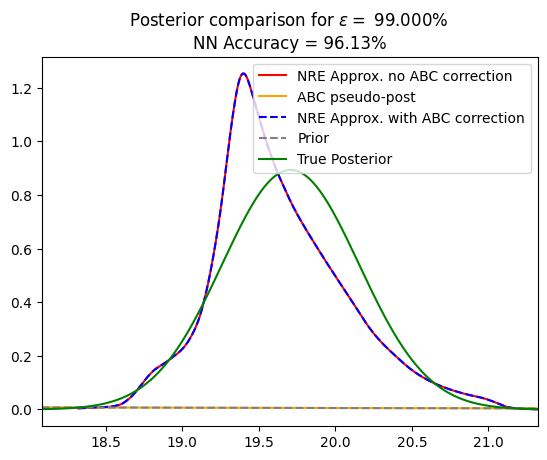

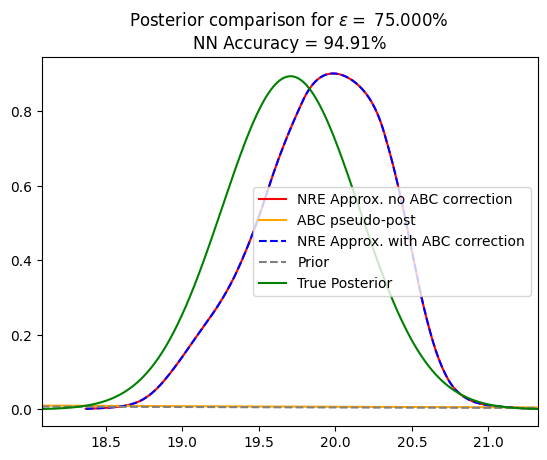

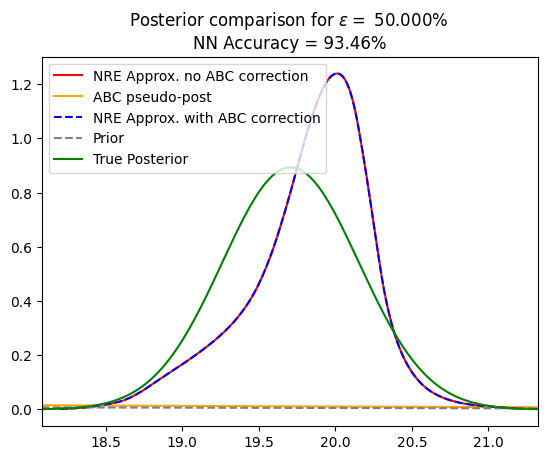

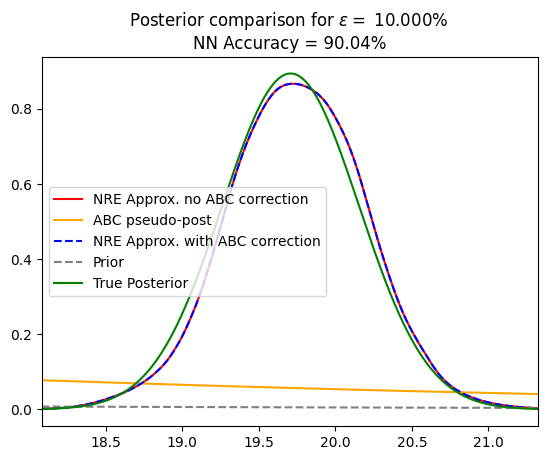

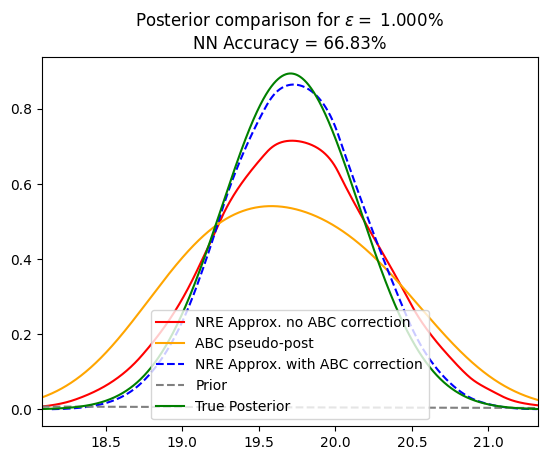

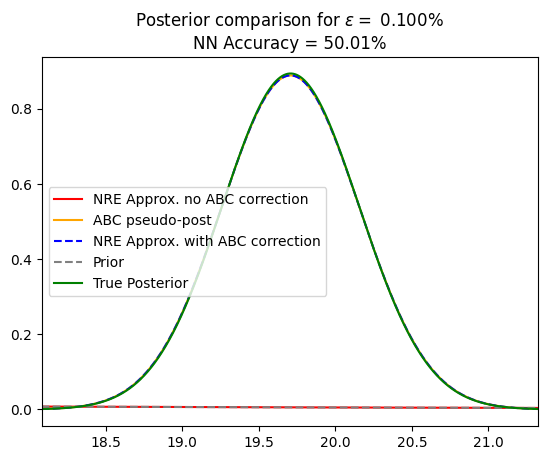

In [108]:
from jax.scipy.stats import norm, gaussian_kde
from functions.SBC import new_post_pdf_z
MINN, MAXX = -100, 100
PRIOR_LOGPDF = lambda x: norm.logpdf(x, loc = MU0, scale = SIGMA0)
prior_pdf = lambda x: norm.pdf(x, loc = MU0, scale = SIGMA0)
prior = stats.norm(loc = MU0, scale = SIGMA0)
posterior = true_post
likelihood = lambda x: jnp.exp(jnp.sum((x-TRUE_DATA)**2)/(2*SIGMA**2))
grid_prior, pdf_prior = find_grid_explorative(prior_pdf, 10000, 10000, MINN, MAXX)
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MINN, MAXX)

Z_prior = np.trapz(pdf_prior, grid_prior)
Z_true = np.trapz(pdf_true, grid_true)

for alpha in ALPHAS:
    EPSILON_STAR = EPSILONS[alpha]
    kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior)

    params = PARAMS[alpha] 
    grid_pseudo, pdf_pseudo = find_grid_explorative(lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILON_STAR, prior), 10000, 10000, MINN, MAXX)
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
    Z_pseudo = np.trapz(pdf_pseudo, grid_pseudo)
    Z_nn = np.trapz(pdf_nn, grid_nn)
    Z_kde_nn = np.trapz(pdf_kde_nn, grid_kde_nn)
    
    plt.plot(grid_nn, pdf_nn/Z_nn, label = 'NRE Approx. no ABC correction', color = "red")
    plt.plot(grid_pseudo, pdf_pseudo/Z_pseudo, label = "ABC pseudo-post", color = "orange")

    plt.plot(grid_kde_nn, pdf_kde_nn/Z_kde_nn, label = "NRE Approx. with ABC correction", color = "blue", linestyle = "--")
    plt.plot(grid_prior, pdf_prior/Z_prior, label = 'Prior', color = "grey", linestyle = "--")
    plt.plot(grid_true, pdf_true/Z_true, label = 'True Posterior', color = "green")





    plt.xlim(np.min(grid_true), np.max(grid_true))
    plt.title(f"Posterior comparison for $\epsilon =$ {alpha:.3%} \nNN Accuracy = {TEST_ACCURACY[alpha]:.2%}")
    plt.legend()
    plt.show()


## Decision function

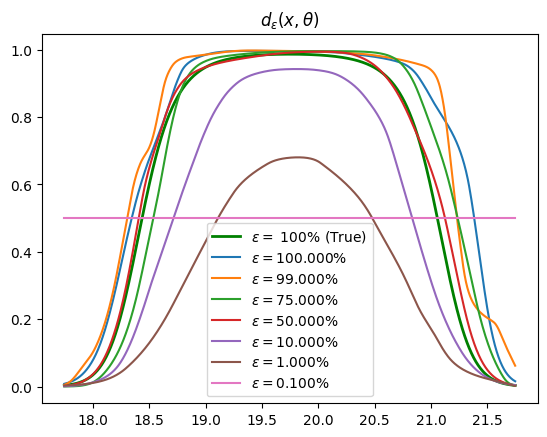

In [62]:
grid = np.linspace(np.mean(TRUE_DATA)-2, np.mean(TRUE_DATA)+2, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
plt.plot(grid, true_decision, color = "green", label = "$\epsilon =$ 100% (True)", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_decision = 1/(1+jnp.exp(-logratio_batch_z(params, grid, TRUE_DATA)))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_decision, label = label)
plt.legend()
plt.title("$d_\epsilon(x,\\theta)$")
plt.show()



## Likelihood-to-evidence ratio

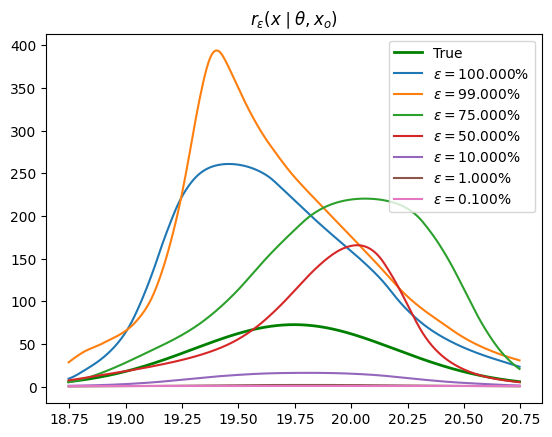

In [54]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio, color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio, label = label)
plt.legend()
plt.title("$r_\epsilon(x\mid \\theta, x_o)$")
plt.show()



## ABC-NRE approximation without correction and normalization

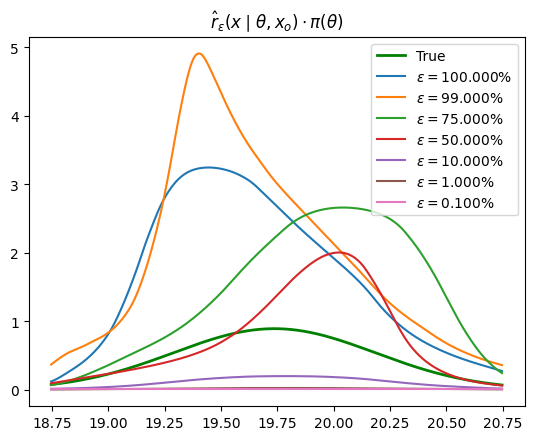

In [63]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
plt.plot(grid, true_ratio*prior.pdf(grid), color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid, approx_ratio*prior.pdf(grid), label = label)
plt.legend()
plt.title("$\hat r_\epsilon(x\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.show()

## ABC-NRE approximation without correction but with normalization

Z_true = 0.9746533661587289
Z_approx (for epsilon = inf) = 3.3
Z_approx (for epsilon = 1.8e+03) = 3.9
Z_approx (for epsilon = 7e+02) = 2.9
Z_approx (for epsilon = 3.9e+02) = 1.5
Z_approx (for epsilon = 5.1e+01) = 0.22
Z_approx (for epsilon = 0.79) = 0.034
Z_approx (for epsilon = 0.0071) = 0.025


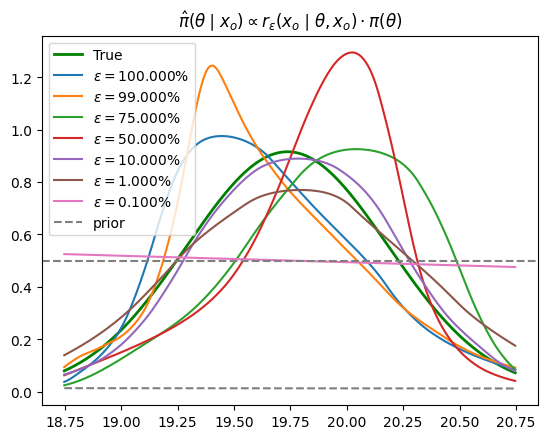

In [56]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = prior.pdf(grid)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx/Z_approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi(\\theta)$")
plt.axhline(0.5, color = "grey", linestyle = "--")
plt.show()

## ABC-NRE approximation with correction but no normalization

/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_15738/1812100366.py:11: RuntimeWarning: divide by zero encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))
/var/folders/bc/mlt2yzpn2hsg7qskk5s47jy40000gn/T/ipykernel_15738/1812100366.py:11: RuntimeWarning: overflow encountered in divide
  return 1/(1+1/true_ratio_z(mus, z, prior, posterior))


(18.12181282043457, 21.362136840820312)

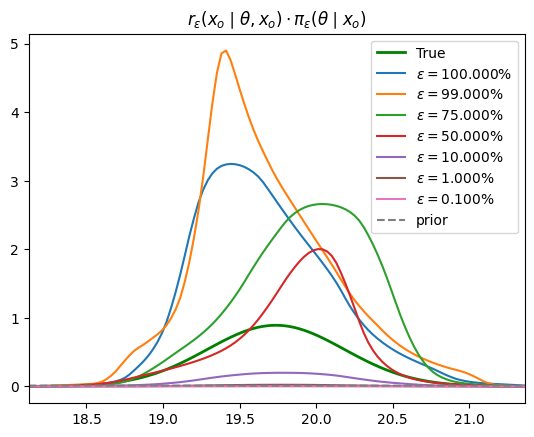

In [57]:
grid = np.linspace(-100, 200, 10000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
plt.plot(grid,true_postt , color = "green", label = "True", lw = 2)
for alpha in ALPHAS:
    params = PARAMS[alpha]
    epsilon = EPSILONS[alpha]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo#/np.trapz(pseudo, grid)
    label = "$\epsilon = ${:.3%}".format(alpha)
    plt.plot(grid,approx, label = label)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")

plt.legend()
plt.title("$r_\epsilon(x_o\mid\\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.xlim(grid_true.min(), grid_true.max())

## ABC-NRE approximation with correction and normalization

Z_true = 0.9746533661587289
Z_approx (for epsilon = inf) = 3.3
Z_approx (for epsilon = 1.8e+03) = 3.9
Z_approx (for epsilon = 7e+02) = 2.9
Z_approx (for epsilon = 3.9e+02) = 1.5
Z_approx (for epsilon = 5.1e+01) = 0.22
Z_approx (for epsilon = 0.79) = 0.028
Z_approx (for epsilon = 0.0071) = 0.002
Z_approx (for epsilon = 7.6e-05) = 0.00021


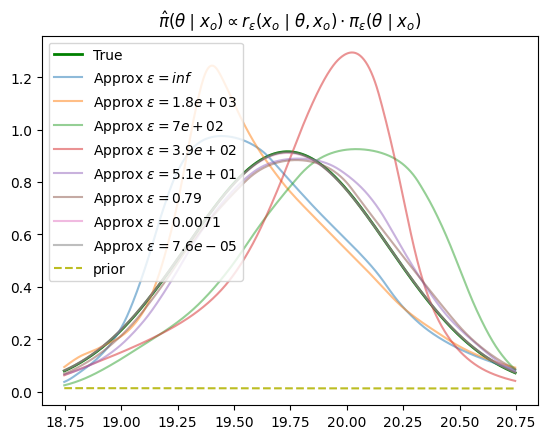

In [64]:
grid = np.linspace(np.mean(TRUE_DATA)-1, np.mean(TRUE_DATA)+1, 1000)
prior = stats.norm(loc = MU0, scale = SIGMA0)
params = PARAMS[1.]
true_decision = true_decision_z(grid, TRUE_DATA, prior, posterior)
true_ratio = true_decision/(1-true_decision)
true_postt = true_ratio*prior.pdf(grid)
Z_true = np.trapz(true_postt, grid)
print('Z_true =', Z_true)
plt.plot(grid,true_postt/Z_true , color = "green", label = "True", lw = 2)
for acc in ACCEPT_RATES:
    params = PARAMS[acc]
    epsilon = EPSILONS[acc]
    approx_ratio = jnp.exp(logratio_batch_z(params, grid, TRUE_DATA))
    pseudo = true_pseudo_post(grid, jnp.mean(TRUE_DATA),epsilon, prior)
    approx = approx_ratio*pseudo
    Z_approx = np.trapz(approx, grid)
    print(f"Z_approx (for epsilon = {epsilon:.2}) = {Z_approx:.2}")
    plt.plot(grid,approx/Z_approx, label = f"Approx $\epsilon = {epsilon:.2}$", alpha = .5)
plt.plot(grid, prior.pdf(grid), label ="prior", linestyle = "--")
plt.legend()
plt.title("$\hat \pi(\\theta \mid x_o) \propto r_\epsilon(x_o\mid \\theta, x_o)\cdot \pi_\epsilon(\\theta\mid x_o)$")
plt.show()

# Classifier 2 Samples Test (C2ST)

In [68]:
from functions.SBC import post_sample, post_sample_batch

In [66]:
from sbibm.metrics import c2st
import torch
from tqdm.notebook import tqdm

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [111]:
C2ST_ABC = {}
C2ST_NN = {}
C2ST_KDE_NN = {}

N_sample = 1000
N_samples = 2
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 1000, 1000, MINN, MAXX)
sample_true = true_post(TRUE_DATA).rvs(N_sample)
key = random.PRNGKey(10)

for alpha in tqdm(np.sort(list(EPSILONS.keys()))[::-1]):
    params = PARAMS[alpha]
    c_alpha = []
    kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILONS[alpha], prior)
    grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
    grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
    accuraccy_abc, accuraccy_nn, accuraccy_kde_nn = [], [], []
    for _ in range(N_samples):
        sample_true = true_post(TRUE_DATA).rvs(N_sample)
        key, key_abc, key_nn, key_kde_nn = random.split(key, 4)
        sample_nn = post_sample(key_nn, grid_nn, pdf_nn, N_sample)
        sample_kde_nn = post_sample(key_kde_nn, grid_kde_nn, pdf_kde_nn, N_sample)
        sample_abc = ABC_gauss(key_abc, TRUE_DATA, EPSILONS[alpha], N_sample)[1]
        if np.isnan(sample_nn).any(): accuraccy_nn.append(1)
        else: accuraccy_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_nn)[:,None]))[0])
        if np.isnan(sample_kde_nn).any(): accuraccy_kde_nn.append(1)
        else: accuraccy_kde_nn.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_kde_nn)[:,None]))[0])
        if np.isnan(sample_abc).any(): accuraccy_abc.append(1)
        else: accuraccy_abc.append(np.array(c2st(torch.tensor(sample_true)[:,None], torch.tensor(sample_abc)))[0])
    C2ST_ABC[alpha] = np.array(accuraccy_abc)
    C2ST_NN[alpha] = np.array(accuraccy_nn)
    C2ST_KDE_NN[alpha] = np.array(accuraccy_kde_nn)
                         
        

  0%|          | 0/8 [00:00<?, ?it/s]

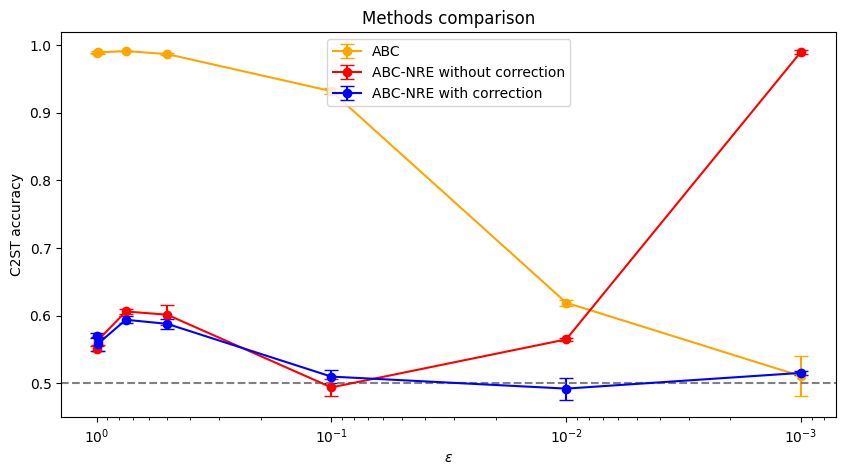

In [112]:
mean_abc = np.array([C2ST_ABC[alpha].mean() for alpha in ALPHAS])
std_abc = np.array([C2ST_ABC[alpha].std() for alpha in ALPHAS])
conf_interval_abc = 1.96*std_abc/np.sqrt(N_samples)

mean_nn = np.array([C2ST_NN[alpha].mean() for alpha in ALPHAS])
std_nn = np.array([C2ST_NN[alpha].std() for alpha in ALPHAS])
conf_interval_nn = 1.96*std_nn/np.sqrt(N_samples)

mean_kde_nn = np.array([C2ST_KDE_NN[alpha].mean() for alpha in ALPHAS])
std_kde_nn = np.array([C2ST_KDE_NN[alpha].std() for alpha in ALPHAS])
conf_interval_kde_nn = 1.96*std_kde_nn/np.sqrt(N_samples)
f, ax = plt.subplots(1, 1, figsize = (10, 5))
plt.errorbar(ALPHAS, mean_abc, yerr = conf_interval_abc, label = "ABC", color = "orange", fmt='o-', capsize=5)
plt.errorbar(ALPHAS, mean_nn, yerr = conf_interval_nn, label = "ABC-NRE without correction", color = "red", fmt='o-', capsize=5)
plt.errorbar(ALPHAS, mean_kde_nn, yerr = conf_interval_kde_nn, label = "ABC-NRE with correction", color = "blue", fmt='o-', capsize=5)

plt.title("Methods comparison")
plt.xlabel("$\epsilon$")
plt.gca().invert_xaxis()
plt.xscale("log")
plt.ylabel("C2ST accuracy")
plt.axhline(.5, color = "grey", linestyle = "--")
plt.legend(loc = "upper center")
plt.show()

Text(0.5, 1.0, 'Posterior comparison')

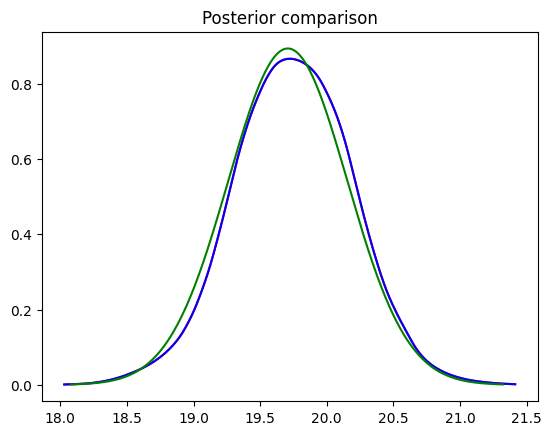

In [110]:
params = PARAMS[.1]
kde_approx = lambda x: true_pseudo_post(x, np.mean(TRUE_DATA), EPSILONS[.1], prior)
grid_nn, pdf_nn = find_grid_explorative(lambda x: post_pdf_z(params, x, TRUE_DATA, PRIOR_LOGPDF), 10000, 10000, MINN, MAXX)
grid_kde_nn, pdf_kde_nn = find_grid_explorative(lambda x: new_post_pdf_z(params, x, TRUE_DATA, kde_approx), 10000, 10000, MINN, MAXX)
grid_true, pdf_true = find_grid_explorative(lambda x: true_post(TRUE_DATA).pdf(x), 10000, 10000, MINN, MAXX)
plt.plot(grid_nn, pdf_nn/np.trapz(pdf_nn, grid_nn), label = "NRE Approx. no ABC correction", color = "red")
plt.plot(grid_kde_nn, pdf_kde_nn/np.trapz(pdf_kde_nn, grid_kde_nn), label = "NRE Approx. with ABC correction", color = "blue")
plt.plot(grid_true, pdf_true/np.trapz(pdf_true, grid_true), label = "True Posterior", color = "green")
# plt.plot(grid_prior, pdf_prior/np.trapz(pdf_prior, grid_prior), label = "Prior", color = "grey")
plt.title("Posterior comparison")

# On the choice on $\epsilon$

In [ ]:


SIGMA0 = 1
SIGMA = 10
N_ABC = 1000000
MU0 = 0
N_DATA = 10
TRUE_DATA = stats.norm.rvs(scale = SIGMA, size = N_DATA)
key = random.PRNGKey(0)
datas, thetas, dists, key = ABC_epsilon(key, N_ABC, prior_simulator, data_simulator, discrepancy, jnp.inf, TRUE_DATA)
index = jnp.argsort(dists)
datas, thetas, dists = datas[index], thetas[index], dists[index]
## alpha
# plot the plot of cdf of dists with interpolation
plt.plot(dists, jnp.linspace(0,1, len(dists)))
plt.title("CDF of distances")
plt.gca().invert_xaxis()
plt.xscale("log")
## beta
p = [1.,.95,.9,.8,.7,.5,.25,.1,.09,.08,.07,.06,.05,.04,.03,.02,.01, .005, .001,.0009,.0005]
epsilons = np.quantile(dists, p)
N_ABC = 1000
betas =[]
for epsilon in epsilons:
    new_datas, new_thetas, new_dists, key = ABC_epsilon(key, N_ABC, prior_simulator, data_simulator, discrepancy, epsilon, TRUE_DATA)
    key, subkey = random.split(key)
    keys_pred = random.split(subkey, N_ABC)
    datas_pred = vmap(data_simulator, in_axes=(0, 0))(keys_pred, new_thetas.reshape(-1,1))
    new_new_dists = vmap(discrepancy, in_axes=(0, None))(datas_pred, TRUE_DATA)
    beta = jnp.mean(new_new_dists < epsilon)
    betas.append(beta)
    print(f"beta for epsilon = {epsilon:.2} is {beta:.2}")
    

plt.plot(dists, jnp.linspace(0,1, len(dists)))
# plt.plot(np.interp(np.linspace(0,1, len(dists)), epsilons, betas), np.linspace(0,1, len(dists)))
plt.plot(epsilons, betas)
plt.title("CDF of distances")
plt.gca().invert_xaxis()
plt.xscale("log")
N_DATA = 10
SIGMA =1
MU0 = 0.
SIGMA0 = 10.
EPSILON = 10. 
TRUE_DATA = stats.norm.rvs(size = N_DATA, scale = SIGMA)
key = random.PRNGKey(0)
mus, zs, key = ABC_gauss(key, TRUE_DATA, EPSILON, 1000000)
import seaborn as sns
sns.kdeplot(mus, label = "Mus")
grid = np.linspace(stats.norm(MU0, SIGMA0).ppf(0.001), stats.norm(MU0, SIGMA0).ppf(0.999), 1000)
plt.plot(grid, stats.norm(MU0, SIGMA0).pdf(grid), label = "Prior")
true_postt = true_pseudo_post(grid, np.mean(TRUE_DATA), EPSILON, stats.norm(MU0, SIGMA0))
plt.plot(grid, true_postt/np.trapz(true_postt,grid), label = "True Pseudo Posterior")
# New approach


In [113]:
C2ST_ABC

{1.0: array([0.989 , 0.9885], dtype=float32),
 0.99: array([0.991 , 0.9875], dtype=float32),
 0.75: array([0.991 , 0.9915], dtype=float32),
 0.5: array([0.9855, 0.988 ], dtype=float32),
 0.1: array([0.9355, 0.9285], dtype=float32),
 0.01: array([0.6225, 0.616 ], dtype=float32),
 0.001: array([0.5325, 0.489 ], dtype=float32),
 0.0001: array([0.5185, 0.464 ], dtype=float32)}